In [1]:
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from skopt import dummy_minimize, gp_minimize
from skopt.plots import plot_convergence, plot_evaluations, plot_objective
from tqdm import tqdm

from environments import ARESEAOptimization, ResetActuatorsToDFD

In [16]:
def pack_dataframe(fn):
    def wrapper(env, problem=None):
        observations, incoming, misalignments, res = fn(env, problem=problem)
        observations = np.array(observations)

        df = pd.DataFrame(np.arange(len(observations)), columns=["step"])
        df["q1"] = observations[:,0]
        df["q2"] = observations[:,1]
        df["q3"] = observations[:,2]
        df["cv"] = observations[:,3]
        df["ch"] = observations[:,4]
        df["mup_x"] = observations[:,5]
        df["mup_y"] = observations[:,6]
        df["sigmap_x"] = observations[:,7]
        df["sigmap_y"] = observations[:,8]
        df["mu_x"] = observations[:,9]
        df["mu_y"] = observations[:,10]
        df["sigma_x"] = observations[:,11]
        df["sigma_y"] = observations[:,12]
        for k in incoming.keys():
            df["incoming_"+k] = float(incoming[k])
        df["misalignment_q1"] = misalignments[0]
        df["misalignment_q2"] = misalignments[1]
        df["misalignment_q3"] = misalignments[2]
        df["misalignment_screen"] = misalignments[4]
        df.loc[:,"res"] = [res] * len(df)

        return df
    
    return wrapper

In [17]:
@pack_dataframe
def run(env, problem=None):
    if problem is not None:
        if "initial" in problem:
            env.next_initial = problem["initial"]
        if "incoming" in problem:
            env.backend.next_incoming = problem["incoming"]
        if "misalignments" in problem:
            env.backend.next_misalignments = problem["misalignments"]
        if "desired" in problem:
            env.next_desired = problem["desired"]

    observations = []

    observation = env.reset()

    observations.append(observation)
    incoming = env.backend._incoming.parameters
    misalignments = env.backend.misalignments

    def optfn(x):
        observation, reward, _, _ = env.step(x)
        observations.append(observation)
        return reward

    bounds = [
        (env.action_space.low[0], env.action_space.high[0]),
        (env.action_space.low[1], env.action_space.high[1]),
        (env.action_space.low[2], env.action_space.high[2]),
        (env.action_space.low[3], env.action_space.high[3]),
        (env.action_space.low[4], env.action_space.high[4])
    ]

    res = gp_minimize(optfn, bounds, x0=list(observation[:5]), n_jobs=-1)

    observation, _, _, _ = env.step(res.x)
    observations.append(observation)

    return observations, incoming, misalignments, res

In [18]:
def cache_to_file(fn):
    def wrapper(method, **kwargs):
        filename = f".cache_3/{method}.pkl"
        
        try:
            evaluation = pd.read_pickle(filename)
            print(f"Read {method} from cache file")
        except FileNotFoundError:
            evaluation = fn(method, **kwargs)
            evaluation.to_pickle(filename)
        
        return evaluation

    return wrapper

In [19]:
@cache_to_file
def evaluate(method, description=None):
    env = ARESEAOptimization(objective=method[-3:], backendargs={"measure_beam": "direct"})
    env = ResetActuatorsToDFD(env)

    with open("problems_3.json", "r") as f:
        problems = json.load(f)

    evaluation = []
    for i, problem in enumerate(tqdm(problems)):
        result = run(env, problem=problem)
        result["problem"] = i
        evaluation.append(result)
    evaluation = pd.concat(evaluation)
    evaluation["method"] = method
    evaluation["model"] = method
    if description is not None:
        evaluation["description"] = description
    
    return evaluation

In [20]:
optimization_evaluation = pd.concat([
    evaluate("bayesian2-mae", description="Bayesian Optimisation with MAE (scipy-optimize)"),
    evaluate("bayesian2-mse", description="Bayesian Optimisation with MSE (scipy-optimize)"),
    evaluate("bayesian2-log", description="Bayesian Optimisation with Our Log Objective (scipy-optimize)")
])

 16%|█▌        | 47/300 [54:58<4:55:55, 70.18s/it]


KeyboardInterrupt: 

In [3]:
results = {}
for obj in ["mae","mse","log"]:
    env = ARESEAOptimization(objective=obj, backendargs={"measure_beam": "direct"})
    env = ResetActuatorsToDFD(env)

    results[obj] = []

    for problem in tqdm(problems[:10]):
        env.next_initial = problem["initial"]
        env.backend.next_incoming = problem["incoming"]
        env.backend.next_misalignments = problem["misalignments"]
        env.next_desired = problem["desired"]

        env.reset()

        def optfn(x):
            _, reward, _, _ = env.step(x)
            return reward

        bounds = [
            (env.action_space.low[0], env.action_space.high[0]),
            (env.action_space.low[1], env.action_space.high[1]),
            (env.action_space.low[2], env.action_space.high[2]),
            (env.action_space.low[3], env.action_space.high[3]),
            (env.action_space.low[4], env.action_space.high[4])
        ]
        res = gp_minimize(optfn, bounds)

        env.step(res.x)
        beam = env.backend.compute_beam_parameters()

        results[obj].append({"res": res, "beam": beam})

 20%|██        | 2/10 [02:29<09:52, 74.12s/it]/usr/local/Caskroom/miniconda/base/envs/rl39/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/Caskroom/miniconda/base/envs/rl39/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/Caskroom/miniconda/base/envs/rl39/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
/usr/local/Caskroom/miniconda/base/envs/rl39/lib/python3.9/site-packages/skopt/optimizer/optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
 90%|█████████ | 9/10 [12:14<01:23, 83.64s/it]

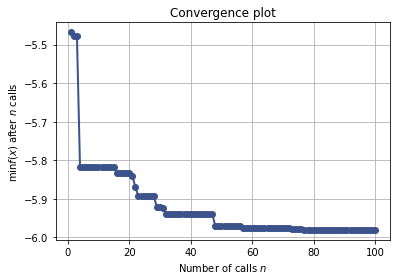

In [9]:
plot_convergence(results["log"][0])
plt.show()

In [11]:
results["log"][0].fun

-5.980710422504332

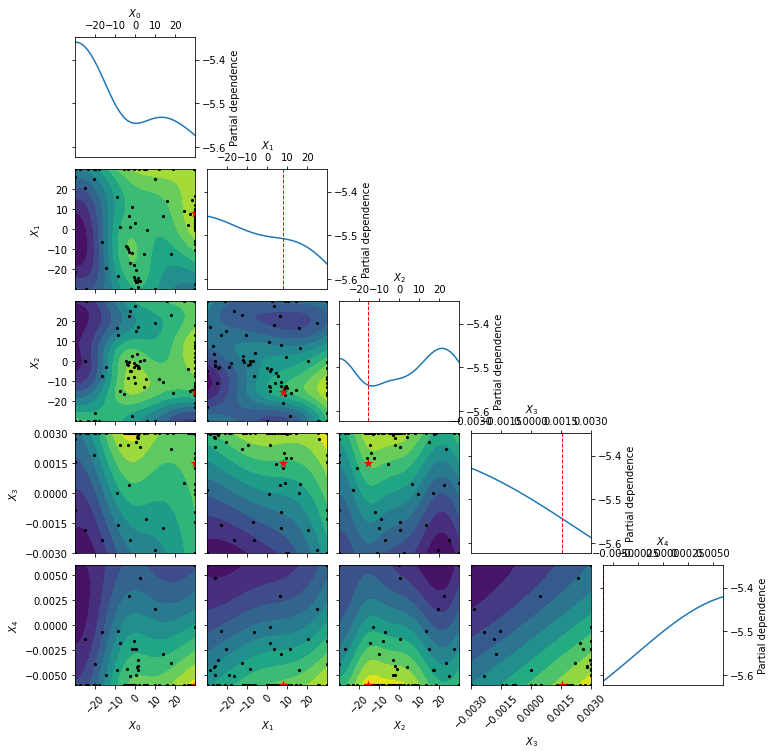

In [10]:
plot_objective(results["log"][0])
plt.show()

In [5]:
results["mae"][0].x

[10.77809422641527,
 23.94879676528187,
 23.161032477167694,
 -0.0017702675594653814,
 -0.004949621741687083]

In [2]:
env = ARESEAOptimization()

In [3]:
env.next_initial = [-10, 10, -10, 0, 0]
env.backend.next_misalignments = [0, 0, 0, 0, 0, 0, 0, 0]
env.next_desired = [0, 0, 0, 0]

env.reset()

array([-1.00000000e+01,  1.00000000e+01, -1.00000000e+01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  2.22426600e-04,  1.00322900e-04,  9.02196178e-05,
        8.31218684e-06])

In [4]:
def optfn(x):
    _, reward, _, _ = env.step(x)
    return reward

bounds = [
    (env.action_space.low[0], env.action_space.high[0]),
    (env.action_space.low[1], env.action_space.high[1]),
    (env.action_space.low[2], env.action_space.high[2]),
    (env.action_space.low[3], env.action_space.high[3]),
    (env.action_space.low[4], env.action_space.high[4])
]
res = gp_minimize(optfn, bounds)

res.fun

1.599540350727971e-09

In [5]:
env.next_initial = [-10, 10, -10, 0, 0]
env.backend.next_misalignments = [0, 0, 0, 0, 0, 0, 0, 0]
env.next_desired = [0, 0, 0, 0]

env.reset()

array([-1.00000000e+01,  1.00000000e+01, -1.00000000e+01,  0.00000000e+00,
        0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        0.00000000e+00,  1.95868200e-04, -7.46304500e-05,  1.60703694e-04,
        5.09121444e-05])

In [6]:
dres = dummy_minimize(optfn, bounds)
dres.fun

-7.694526522871485

In [7]:
3.066132823779193e-05**2

9.401170493056168e-10

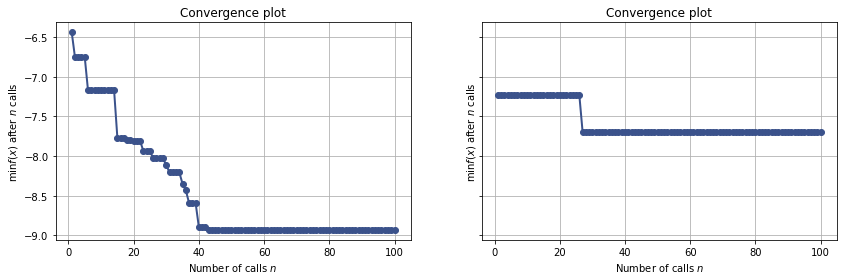

In [9]:
fig, (ax0,ax1) = plt.subplots(ncols=2, figsize=(14,4), sharey=True)
plot_convergence(res, ax=ax0)
plot_convergence(dres, ax=ax1)
plt.show()

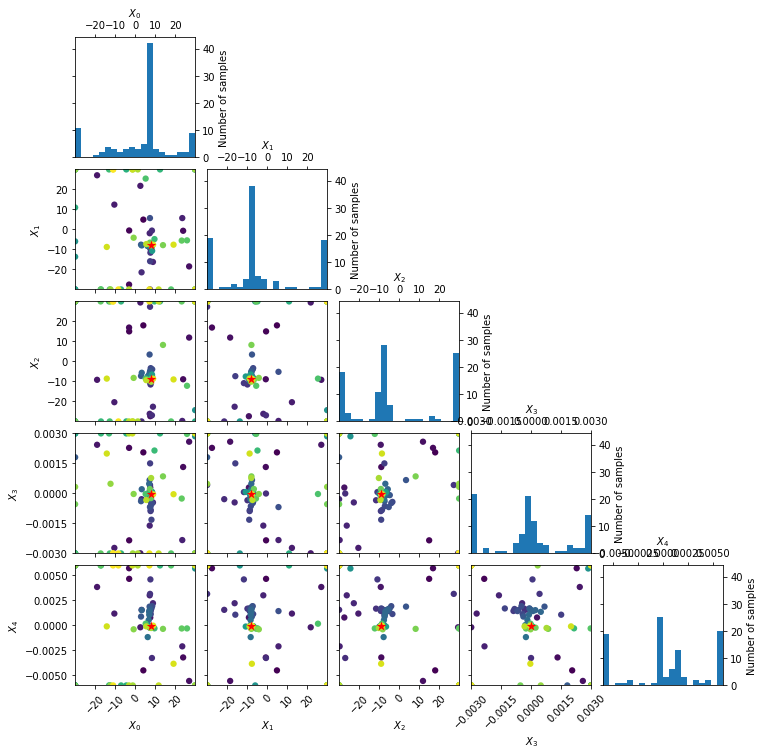

In [10]:
plot_evaluations(res)
plt.show()

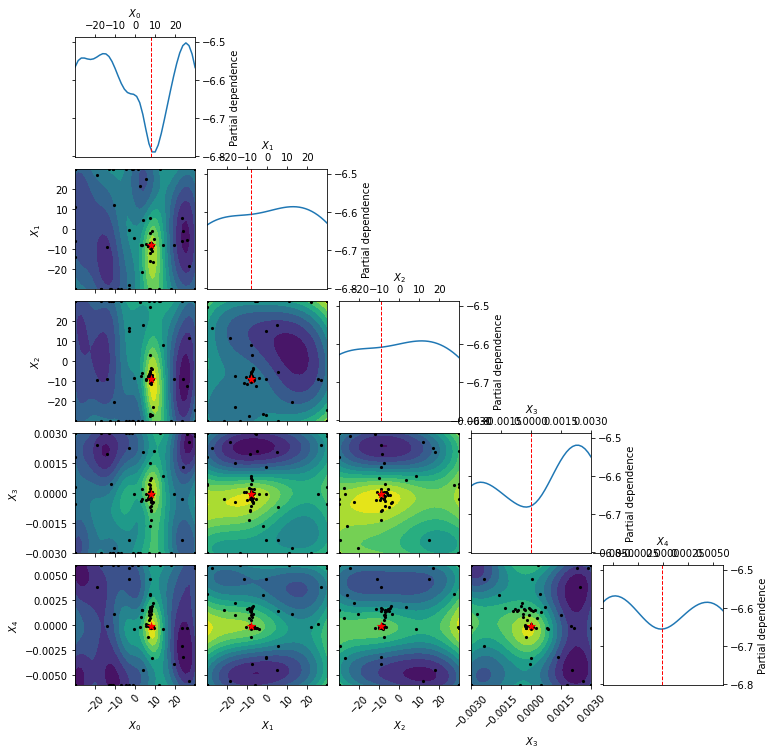

In [11]:
plot_objective(res)
plt.show()

In [1]:
import pandas as pd

In [2]:
df = pd.read_pickle(".cache_3/bayesian2-mae.pkl")

In [3]:
df

,step,q1,q2,q3,cv,ch,mup_x,mup_y,sigmap_x,sigmap_y,...,incoming_sigma_p,incoming_energy,misalignment_q1,misalignment_q2,misalignment_q3,misalignment_screen,problem,method,model,description
0,0,10.000000,-10.000000,10.000000,0.000000,0.000000,-0.001085,0.000970,0.000036,0.000443,...,0.000685,8.836014e+07,0.000303,-0.000092,0.000299,0.000237,0,bayesian2-mae,bayesian2-mae,Bayesian Optimisation with MAE (scipy-optimize)
1,1,10.000000,-10.000000,10.000000,0.000000,0.000000,-0.001085,0.000970,0.000036,0.000443,...,0.000685,8.836014e+07,0.000303,-0.000092,0.000299,0.000237,0,bayesian2-mae,bayesian2-mae,Bayesian Optimisation with MAE (scipy-optimize)
2,2,19.865950,5.751370,5.344543,-0.002829,-0.002337,-0.001085,0.000970,0.000036,0.000443,...,0.000685,8.836014e+07,0.000303,-0.000092,0.000299,0.000237,0,bayesian2-mae,bayesian2-mae,Bayesian Optimisation with MAE (scipy-optimize)
3,3,-24.020666,18.140982,-21.180220,0.002615,-0.004852,-0.001085,0.000970,0.000036,0.000443,...,0.000685,8.836014e+07,0.000303,-0.000092,0.000299,0.000237,0,bayesian2-mae,bayesian2-mae,Bayesian Optimisation with MAE (scipy-optimize)
4,4,-21.184853,1.969548,26.639088,0.001840,-0.001898,-0.001085,0.000970,0.000036,0.000443,...,0.000685,8.836014e+07,0.000303,-0.000092,0.000299,0.000237,0,bayesian2-mae,bayesian2-mae,Bayesian Optimisation with MAE (scipy-optimize)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,97,-29.605392,15.403768,19.109929,-0.002570,0.005844,0.000289,-0.001588,0.000424,0.000160,...,0.000499,1.028377e+08,-0.000022,-0.000016,0.000363,0.000279,299,bayesian2-mae,bayesian2-mae,Bayesian Optimisation with MAE (scipy-optimize)
98,98,0.304685,1.835246,-26.420826,0.002869,-0.005282,0.000289,-0.001588,0.000424,0.000160,...,0.000499,1.028377e+08,-0.000022,-0.000016,0.000363,0.000279,299,bayesian2-mae,bayesian2-mae,Bayesian Optimisation with MAE (scipy-optimize)
99,99,-25.946865,30.000000,-30.000000,-0.000548,-0.006000,0.000289,-0.001588,0.000424,0.000160,...,0.000499,1.028377e+08,-0.000022,-0.000016,0.000363,0.000279,299,bayesian2-mae,bayesian2-mae,Bayesian Optimisation with MAE (scipy-optimize)
100,100,-2.562137,-10.764082,-29.287596,-0.002781,0.005846,0.000289,-0.001588,0.000424,0.000160,...,0.000499,1.028377e+08,-0.000022,-0.000016,0.000363,0.000279,299,bayesian2-mae,bayesian2-mae,Bayesian Optimisation with MAE (scipy-optimize)
